Esse notebook tem como objetivo o desenvolvimento do modelo Baseline de behavior solicitado pela claro para avaliar se clientes pré-pago virariam ou não inadimplentes ao migrar para plano controle.
Esse modelo irá utilizar todas as bases de dados disponíveis pela Claro(BUREAL + TELCO + Cadastro + booking recarga + booking pagamento + booking atraso)


#BIBLIOTECAS E INSTALAÇÕES

In [1]:
!apt-get update -qq > /dev/null
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [2]:
# manipulação, leitura e vizualização de dados bibiliotecas
import matplotlib.pyplot as plt
import pandas            as pd
import seaborn           as sns
import numpy             as np

In [3]:
# Configurar o Pandas para não usar notação científica para floats e exibir com 2 casas decimais
pd.set_option('display.float_format', '{:.6f}'.format)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
#pd.reset_option('display.width')
#pd.reset_option('display.max_colwidth')

In [4]:
#machilne learning bibliotecas
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, FunctionTransformer
!pip install category_encoders
from category_encoders import TargetEncoder, WOEEncoder, CatBoostEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, auc
from sklearn.linear_model import LogisticRegression
!pip install catboost
import catboost as cb
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV, SelectKBest, f_classif, SelectFromModel
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 11.3 MB/s eta 0:00:00


#FUNÇÕES

In [5]:
# Criar variável para metadados
# (nomes das colunas, tipos, quantidade de nulos, percentual de nulos, cardinalidade)

def generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes.astype(str), # Convert dtypes to string for sorting
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': ((dataframe.isnull().sum() / len(dataframe)) * 100).round(2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata = metadata.sort_values(by='tipo')
    metadata = metadata.reset_index(drop=True)

    return metadata

In [6]:
# Métricas do modelo

def calculate_metrics(nm_modelo, model, X_train, y_train, X_test, y_test):
    # Fazendo predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculando as métricas para o conjunto de treino
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    auc_roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de treino
    probabilities_train = model.predict_proba(X_train)[:, 1]
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': probabilities_train})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))
    gini_index_train = 2 * auc_roc_train - 1

    # Calculando as métricas para o conjunto de teste
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    auc_roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de teste
    probabilities_test = model.predict_proba(X_test)[:, 1]
    df_test = pd.DataFrame({'true_labels': y_test, 'predicted_probs': probabilities_test})
    df_test = df_test.sort_values(by='predicted_probs', ascending=False)
    df_test['cumulative_true'] = df_test['true_labels'].cumsum() / df_test['true_labels'].sum()
    df_test['cumulative_false'] = (1 - df_test['true_labels']).cumsum() / (1 - df_test['true_labels']).sum()
    ks_statistic_test = max(abs(df_test['cumulative_true'] - df_test['cumulative_false']))
    gini_index_test = 2 * auc_roc_test - 1

    # Criando o DataFrame com as métricas calculadas
    metrics_df = pd.DataFrame({
        'Algoritmo': [nm_modelo, nm_modelo],
        'Conjunto': ['Treino', 'Teste'],
        'Acuracia': [accuracy_train, accuracy_test],
        'Precisao': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'AUC_ROC': [auc_roc_train, auc_roc_test],
        'GINI': [gini_index_train, gini_index_test],
        'KS': [ks_statistic_train, ks_statistic_test]
    })
    return metrics_df

def plot_metrics(model, X_train, y_train, X_test, y_test, features):
    plt.figure(figsize=(15, 18))

    # Gráfico de Barras para Taxa do Evento e Importância das Variáveis
    plt.subplot(4, 2, 1)
    event_rate = y_train.mean()
    non_event_rate = 1 - event_rate
    plt.barh(['Não Evento', 'Evento'], [non_event_rate, event_rate], color=['lightsteelblue', 'skyblue'])
    plt.xlabel('Taxa')
    plt.title('Taxa do Evento')

    plt.subplot(4, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)  # Ordem ascendente
    indices = indices[-10:]  # Considerando apenas as 10 mais importantes
    plt.barh(features[indices], importances[indices], color='skyblue')
    plt.xlabel('Importância')
    plt.title('Importância das Variáveis')

    # Curva ROC para Treino e Teste
    plt.subplot(4, 2, 3)
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')

    # Gráfico de Barras para Gini e KS
    plt.subplot(4, 2, 4)
    metrics = ['Índice Gini', 'Estatística KS']
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        probs = model.predict_proba(X)[:, 1]
        df = pd.DataFrame({'true_labels': y, 'predicted_probs': probs})
        df = df.sort_values(by='predicted_probs', ascending=False)
        df['cumulative_true'] = df['true_labels'].cumsum() / df['true_labels'].sum()
        df['cumulative_false'] = (1 - df['true_labels']).cumsum() / (1 - df['true_labels']).sum()
        ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
        gini = 2 * auc(*roc_curve(y, probs)[:2]) - 1
        plt.bar([f'{label}\n{metric}' for metric in metrics], [gini, ks], color='skyblue')
    plt.title('Índice Gini e Estatística KS')

    # Matrizes de Confusão para Treino e Teste
    for i, (X, y, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')], 5):
        plt.subplot(4, 2, i)
        conf_matrix = confusion_matrix(y, model.predict(X))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusão - {label}')

    # Histograma do Score para Treino e Teste
    plt.subplot(4, 2, 7)
    plt.hist(model.predict_proba(X_train)[:, 1], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Treino')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Treino')
    plt.legend(loc='upper right')

    plt.subplot(4, 2, 8)
    plt.hist(model.predict_proba(X_test)[:, 1], bins=30, color='lightsteelblue', edgecolor='black', alpha=0.7, label='Teste')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Teste')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [7]:
def plot_metrics(model, X_train, y_train, X_test, y_test, features):
    plt.figure(figsize=(15, 18))

    # Gráfico de Barras para Taxa do Evento e Importância das Variáveis
    plt.subplot(4, 2, 1)
    event_rate = y_train.mean()
    non_event_rate = 1 - event_rate
    plt.barh(['Não Evento', 'Evento'], [non_event_rate, event_rate], color=['lightsteelblue', 'skyblue'])
    plt.xlabel('Taxa')
    plt.title('Taxa do Evento')

    plt.subplot(4, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)  # Ordem ascendente
    indices = indices[-10:]  # Considerando apenas as 10 mais importantes
    plt.barh(features[indices], importances[indices], color='skyblue')
    plt.xlabel('Importância')
    plt.title('Importância das Variáveis')

    # Curva ROC para Treino e Teste
    plt.subplot(4, 2, 3)
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')

    # Gráfico de Barras para Gini e KS
    plt.subplot(4, 2, 4)
    metrics = ['Índice Gini', 'Estatística KS']
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        probs = model.predict_proba(X)[:, 1]
        df = pd.DataFrame({'true_labels': y, 'predicted_probs': probs})
        df = df.sort_values(by='predicted_probs', ascending=False)
        df['cumulative_true'] = df['true_labels'].cumsum() / df['true_labels'].sum()
        df['cumulative_false'] = (1 - df['true_labels']).cumsum() / (1 - df['true_labels']).sum()
        ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
        gini = 2 * auc(*roc_curve(y, probs)[:2]) - 1
        plt.bar([f'{label}\n{metric}' for metric in metrics], [gini, ks], color='skyblue')
    plt.title('Índice Gini e Estatística KS')

    # Matrizes de Confusão para Treino e Teste
    for i, (X, y, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')], 5):
        plt.subplot(4, 2, i)
        conf_matrix = confusion_matrix(y, model.predict(X))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusão - {label}')

    # Histograma do Score para Treino e Teste
    plt.subplot(4, 2, 7)
    plt.hist(model.predict_proba(X_train)[:, 1], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Treino')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Treino')
    plt.legend(loc='upper right')

    plt.subplot(4, 2, 8)
    plt.hist(model.predict_proba(X_test)[:, 1], bins=30, color='lightsteelblue', edgecolor='black', alpha=0.7, label='Teste')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Teste')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [8]:
import sklearn.feature_selection

# Get a list of all attributes (modules, functions, classes) in sklearn.feature_selection
available_modules = dir(sklearn.feature_selection)

# Filter out private/internal attributes and print them
print("Available modules and functions in sklearn.feature_selection:")
for item in sorted(available_modules):
    if not item.startswith('_'): # Exclude private members
        print(f"- {item}")

Available modules and functions in sklearn.feature_selection:
- GenericUnivariateSelect
- RFE
- RFECV
- SelectFdr
- SelectFpr
- SelectFromModel
- SelectFwe
- SelectKBest
- SelectPercentile
- SelectorMixin
- SequentialFeatureSelector
- VarianceThreshold
- chi2
- f_classif
- f_oneway
- f_regression
- mutual_info_classif
- mutual_info_regression
- r_regression


In [9]:
def discretize_numeric_features(df, bins):
    df_discretized = df.copy()
    for col in df.columns:
        if df[col].dtype in ['float64', 'float32', 'int64', 'int32'] and len(df[col].unique()) > bins:
            df_discretized[col] = pd.cut(df[col], bins=bins, labels=False, duplicates='drop')
    return df_discretized

def calculate_iv(df, feature, target):
    lst = []
    for value in df[feature].unique():
        lst.append({
            'Value': value,
            'All': df[df[feature] == value].count()[feature],
            'Good': df[(df[feature] == value) & (df[target] == 1)].count()[feature],
            'Bad': df[(df[feature] == value) & (df[target] == 0)].count()[feature]
        })

    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = (dset['Good'] + 0.0001) / (dset['Good'].sum() + 0.0001)  # Adding a small value to avoid division by zero
    dset['Distr_Bad'] = (dset['Bad'] + 0.0001) / (dset['Bad'].sum() + 0.0001)  # Adding a small value to avoid division by zero
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad']).replace({np.inf: 0, -np.inf: 0})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    return dset['IV'].sum()

def classify_iv(iv_value):
    if iv_value < 0.02:
        return "Muito Fraco"
    elif iv_value < 0.1:
        return "Fraco"
    elif iv_value < 0.3:
        return "Moderado"
    elif iv_value < 0.5:
        return "Forte"
    else:
        return "Muito Forte"

# def select_features_by_iv_with_progress(df, target, iv_cutoff_ratio=1.0):
#     from tqdm import tqdm
#     iv_stats = []
#     for col in tqdm(df.columns, desc="Calculating IV", unit="variable"):
#         if col != target:
#             iv_value = calculate_iv(df, col, target)
#             iv_stats.append({
#                 'Variable': col,
#                 'IV': iv_value,
#                 'Predictiveness': classify_iv(iv_value)
#             })

#     iv_df = pd.DataFrame(iv_stats).sort_values(by='IV', ascending=False)
#     max_iv = iv_df['IV'].max()
#     cutoff_value = iv_cutoff_ratio * max_iv
#     selected_features = iv_df[iv_df['IV'] >= cutoff_value]['Variable'].tolist()

#     return selected_features, iv_df

def select_features_by_iv_discretized(df, target, iv_cutoff_ratio=1.0, bins=10):
    from tqdm import tqdm
    df = discretize_numeric_features(df, bins)

    iv_stats = []
    for col in tqdm(df.columns, desc="Calculating IV", unit="variable"):
        if col != target:
            iv_value = calculate_iv(df, col, target)
            iv_stats.append({
                'Variable': col,
                'IV': iv_value,
                'Predictiveness': classify_iv(iv_value)
            })

    iv_df = pd.DataFrame(iv_stats).sort_values(by='IV', ascending=False)
    max_iv = iv_df['IV'].max()
    cutoff_value = iv_cutoff_ratio * max_iv
    selected_features = iv_df[iv_df['IV'] >= cutoff_value]['Variable'].tolist()

    return selected_features, iv_df

In [10]:
# Função corrigida
def substituir_erros_para_nan(X, valores_errados_list):
    import pandas as pd
    import numpy as np
    X = pd.DataFrame(X)
    return X.replace(valores_errados_list, np.nan)

In [11]:
#conectando com google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LEITURA E PADRONIZAÇÃO DA BASE DE DADOS

## Booking Pagamento

In [12]:
#lendo booking de variaveis criado a partir da base de recarga:
df_pagamento = pd.read_parquet('/content/drive/MyDrive/bases_CLARO_CREDITO/book_pagamento_merged_combined.parquet')

In [13]:
#tamanho da tabela
df_pagamento.shape

(263709, 44)

In [14]:
#olhando algumas linhas da tabela:
df_pagamento.head(5)

,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_9_MESES_PAGAMENTO,VL_MIN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO,VL_MED_VAL_JUROS_MULTAS_ITEM_ULTIMOS_12_MESES_PAGAMENTO,QT_MIN_SEQ_ARQUIVO_PAGAMENTO_ULTIMOS_12_MESES_PAGAMENTO_x,TEND__VAL_PAGAMENTO_FATURA_9_12_MESES_PAGAMENTO,QT_MIN_NUM_AGRUPADOR_PAGAMENTO_ULTIMOS_12_MESES_PAGAMENTO_x,VL_TOT_VAL_JUROS_MULTAS_ITEM_ULTIMOS_12_MESES_PAGAMENTO,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO,QT_AVG_SEQ_ARQUIVO_PAGAMENTO_ULTIMOS_12_MESES_PAGAMENTO_x,ID,FPD_SCORE,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO,VL_MIN_VAL_PAGAMENTO_FATURA_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO,VL_MEDIAN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_NULL,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_NULL,VL_MIN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_NULL,DAT_VENCIMENTO_CREDITO_MIN_STATUS_CREDITO_DIFF,DAT_VENCIMENTO_CREDITO_MIN_CRIACAO_CREDITO_DIFF,VL_TOT_VAL_PAGAMENTO_CREDITO_ULTIMOS_12_MESES_FLAG_B_COD_TIPO_FATURA_PAGAMENTO,VL_TOT_VAL_ORIGINAL_PAGAMENTO_ULTIMOS_12_MESES_FLAG_B_COD_TIPO_FATURA_PAGAMENTO,VL_TOT_VAL_BAIXA_ATIVIDADE_ULTIMOS_12_MESES_FLAG_B_COD_TIPO_FATURA_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_ORIGINAL_PAGAMENTO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_CREDITO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_BAIXA_ATIVIDADE_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_ATUAL_PAGAMENTO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_PAGAMENTO_CREDITO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_ORIGINAL_PAGAMENTO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_BAIXA_ATIVIDADE_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_ATUAL_PAGAMENTO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_CREDITO_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_BAIXA_ATIVIDADE_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_9_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_ATUAL_PAGAMENTO_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_CREDITO_ULTIMOS_9_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_ORIGINAL_PAGAMENTO_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_BAIXA_ATIVIDADE_ULTIMOS_9_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO
0,384.110000,384.110000,54.799999,0.000000,0.000000,1.000000,0.000000,0.000000,54.870000,0.000000,777778UZTN8_202412,0,0.000000,0.000000,0.000000,0.000000,384.110000,54.870000,54.799999,4.000000,4.000000,384.110000,384.110000,384.110000,384.110000,384.110000,384.110000,384.110000,384.110000,54.870000,54.870000,54.870000,54.870000,54.870000,0.000000,384.110000,384.110000,384.110000,384.110000,384.110000,384.110000,0.000000,384.110000,384.110000
1,455.900000,332.060000,30.590000,0.640000,442.000000,0.728361,618.000000,8.320000,35.070000,2271.110000,77777UZ9W87_202503,0,61.300000,30.590000,30.650000,30.590000,98.010000,32.670000,30.590000,-15.000000,-15.000000,394.500000,394.500000,394.500000,182.360000,182.260000,182.260000,182.260000,182.260000,36.450000,36.450000,36.450000,36.450000,36.470000,61.300000,358.600000,358.600000,296.160000,358.600000,358.700000,296.060000,30.650000,358.

In [15]:
generate_metadata(df_pagamento)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,FPD_SCORE,Int64,0,0.000000,2
1,VL_MIN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_P...,float32,0,0.000000,8711
2,VL_MIN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_NULL,float32,0,0.000000,9069
3,VL_MEDIAN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESE...,float32,0,0.000000,10215
4,VL_MIN_VAL_PAGAMENTO_FATURA_VAL_PAGAMENTO_FATU...,float32,0,0.000000,9454
5,VL_TOT_VAL_PAGAMENTO_CREDITO_ULTIMOS_6_MESES_F...,float64,0,0.000000,76173
6,VL_TOT_VAL_BAIXA_ATIVIDADE_ULTIMOS_6_MESES_FLA...,float64,0,0.000000,88499
7,VL_TOT_VAL_ATUAL_PAGAMENTO_ULTIMOS_6_MESES_FLA...,float64,0,0.000000,88499
8,VL_MED_VAL_PAGAMENTO_CREDITO_ULTIMOS_6_MESES_F...,float64,0,0.000000,12739
9,VL_MED_VAL_ORIGINAL_PAGAMENTO_ULTIMOS_6_MESES_...,float64,0,0.000000,20155


## Booking Atraso

In [16]:
#lendo booking de variaveis criado a partir da base de recarga:
df_atraso = pd.read_parquet('/content/drive/MyDrive/bases_CLARO_CREDITO/book_atraso_merged_combined.parquet')

In [17]:
#tamanho da tabela
df_atraso.shape

(293815, 151)

In [18]:
#olhando algumas linhas da tabela:
df_atraso.head(5)

,QT_MAX_NUM_BILL_SEQ_FAT_ULTIMOS_12_MESES_ATRASO,QT_AVG_NUM_BILL_SEQ_FAT_ULTIMOS_12_MESES_ATRASO,QT_AVG_NUM_ENT_SEQ_FATURA_ULTIMOS_9_MESES_ATRASO,tendencia_fat_bruto_bc_3m_12m,QT_AVG_NUM_ENT_SEQ_FATURA_ULTIMOS_12_MESES_ATRASO,QT_MAX_NUM_ENT_SEQ_FATURA_ULTIMOS_12_MESES_ATRASO,VL_TOT_VAL_FAT_CREDITO_ULTIMOS_12_MESES_ATRASO,VL_MAX_VAL_FAT_BRUTO_ULTIMOS_12_MESES_ATRASO,VL_TOT_VAL_FAT_BRUTO_ULTIMOS_6_MESES_ATRASO,VL_MED_VAL_FAT_BRUTO_ULTIMOS_12_MESES_ATRASO,ID,FPD_SCORE,QT_DIAS_ENTRE_ATIVACAO_CONTA_CLI_E_DAT_REFERENCIA_MAX,QT_DIAS_ENTRE_ATIVACAO_CONTA_CLI_E_DAT_REFERENCIA_MIN,QT_DIAS_ALTERACAO_REGISTRO_TRANS,QT_DIAS_ENTRE_CRIACAO_REGISTRO_E_DAT_REFERENCIA_MAX,QT_DIAS_STATUS_FAT,QT_DIAS_ENTRE_CRIACAO_REGISTRO_E_DAT_REFERENCIA_MIN,QT_DIAS_MIN_VENCIMENTO_FAT,QT_DIAS_CRIACAO_FAT,QT_DIAS_ATIVACAO_CONTA_CLI,QT_DIAS_ENTRE_VENCIMENTO_FINAL_E_STATUS_MIN,VL_TOT_VAL_FAT_BRUTO_ULTIMOS_6_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_MEDIAN_VAL_FAT_CREDITO_ULTIMOS_6_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT__ATRASO,VL_TOT_VAL_FAT_CREDITO_ULTIMOS_6_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_MAX_VAL_FAT_CREDITO_ULTIMOS_6_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_MED_VAL_FAT_CREDITO_ULTIMOS_6_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_MED_VAL_FAT_BRUTO_ULTIMOS_6_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_MIN_VAL_FAT_BRUTO_ULTIMOS_6_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_MEDIAN_VAL_FAT_BRUTO_ULTIMOS_6_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT__ATRASO,VL_MED_VAL_FAT_CREDITO_ULTIMOS_3_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_MAX_VAL_FAT_BRUTO_ULTIMOS_6_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_TOT_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_MED_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_MAX_VAL_FAT_CREDITO_ULTIMOS_3_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_MEDIAN_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT__ATRASO,VL_MAX_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_MEDIAN_VAL_FAT_CREDITO_ULTIMOS_3_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT__ATRASO,VL_MIN_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_MAX_VAL_FAT_CREDITO_ULTIMO_1_MES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_TOT_VAL_FAT_CREDITO_ULTIMOS_3_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_TOT_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_N_IND_PRIMEIRA_FAT_ATRASO,VL_MED_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_N_IND_PRIMEIRA_FAT_ATRASO,VL_TOT_VAL_MULTA_JUROS_ULTIMOS_3_MESES_FLAG_N_IND_PRIMEIRA_FAT_ATRASO,VL_TOT_VAL_FAT_ABERTO_ULTIMOS_3_MESES_FLAG_N_IND_PRIMEIRA_FAT_ATRASO,VL_TOT_VAL_FAT_BRUTO_BC_ULTIMOS_3_MESES_FLAG_N_IND_PRIMEIRA_FAT_ATRASO,VL_MED_VAL_MULTA_JUROS_ULTIMOS_3_MESES_FLAG_N_IND_PRIMEIRA_FAT_ATRASO,VL_TOT_VAL_FAT_LIQUIDO_ULTIMOS_3_MESES_FLAG_N_IND_PRIMEIRA_FAT_ATRASO,VL_MAX_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_N_IND_PRIMEIRA_FAT_ATRASO,VL_MED_VAL_FAT_BRUTO_ULTIMO_1_MES_FLAG_S_IND_PRIMEIRA_FAT_ATRASO,VL_MIN_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_N_IND_PRIMEIRA_FAT_ATRASO,VL_TOT_VAL_FAT_BRUTO_ULTIMOS_6_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA_ATRASO,VL_MEDIAN_VAL_FAT_CREDITO_ULTIMOS_6_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA__ATRASO,VL_MAX_VAL_FAT_CREDITO_ULTIMOS_6_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA_ATRASO,VL_TOT_VAL_FAT_CREDITO_ULTIMOS_6_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA_ATRASO,VL_MED_VAL_FAT_CREDITO_ULTIMOS_6_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA_ATRASO,VL_MEDIAN_VAL_FAT_CREDITO_ULTIMOS_3_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA__ATRASO,VL_MED_VAL_FAT_BRUTO_ULTIMOS_6_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA_ATRASO,VL_MAX_VAL_FAT_BRUTO_ULTIMOS_6_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA_ATRASO,VL_MIN_VAL_FAT_BRUTO_ULTIMOS_6_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA_ATRASO,VL_MIN_VAL_FAT_CREDITO_ULTIMOS_6_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA_ATRASO,VL_MED_VAL_FAT_CREDITO_ULTIMOS_12_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA_ATRASO,VL_TOT_VAL_FAT_BRUTO_ULTIMOS_12_MESES_FLAG_RANG

In [19]:
generate_metadata(df_atraso)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,FPD_SCORE,Int64,0,0.000000,2
1,VL_MIN_VAL_FAT_BRUTO_ULTIMOS_12_MESES_FLAG_AUT...,float32,0,0.000000,13843
2,VL_MIN_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_N_IN...,float32,0,0.000000,11665
3,VL_MIN_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_OTHE...,float32,0,0.000000,12572
4,VL_MAX_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_N_IN...,float32,0,0.000000,23436
5,VL_MEDIAN_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_O...,float32,0,0.000000,13450
6,VL_MEDIAN_VAL_FAT_CREDITO_ULTIMOS_12_MESES_FLA...,float32,0,0.000000,5659
7,VL_MAX_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_OTHE...,float32,0,0.000000,22770
8,VL_MAX_VAL_FAT_CREDITO_ULTIMOS_3_MESES_FLAG_OT...,float32,0,0.000000,8334
9,VL_MIN_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_AUTO...,float32,0,0.000000,13563


# CRIAÇÃO ABT para Modelagem

In [20]:
#lendo abt do modelo anterior(modelo 6):
df_abt = pd.read_parquet('/content/drive/MyDrive/bases_CLARO_CREDITO_abt_previa.parquet')

In [21]:
#repetindo processo com dados da base de atraso:
df_abt = df_abt.merge(df_atraso, on = 'ID', how = 'inner') # temos dados para cerca de 300 mil clientes

In [22]:
df_abt.shape

(293815, 335)

### FEATURE ENGINEERING COM COLUNAS DE DATA DA BASE DE CADASTRO

In [23]:
df_abt['IDADE'] = (df_abt['SAFRA_DATA'] - df_abt['DATADENASCIMENTO']).dt.days / 365
df_abt['DIF_VAR_12_NASCIMENTO'] = (df_abt['var_12'] - df_abt['DATADENASCIMENTO']).dt.days
df_abt['DIF_VAR_12_SAFRA'] = (df_abt['SAFRA_DATA'] - df_abt['var_12']).dt.days

In [24]:
metadata_df = generate_metadata(df_abt)

# PREPARAÇÃO DOS DADOS

In [25]:
#eliminando as colunas com 70% de nulos:
missing_cutoff = 70
df_drop_nulos = metadata_df[(metadata_df['percent_nulos'] >= missing_cutoff)]
lista_drop_nulos = list(df_drop_nulos.nome_variavel.values)
lista_drop_nulos

['var_07',
 'var_08',
 'var_10',
 'var_11',
 'var_13',
 'var_14',
 'var_15',
 'var_16',
 'var_17',
 'var_18',
 'var_20',
 'var_22',
 'var_23',
 'var_06',
 'var_02']

In [26]:
#detectando as colunas com 100% de nulos:
missing_cutoff_2 = 100
df_drop_nulos_2 = metadata_df[(metadata_df['percent_nulos'] >= missing_cutoff_2)]
lista_drop_nulos_2 = list(df_drop_nulos_2.nome_variavel.values)
lista_drop_nulos_2

[]

In [27]:
# Colunas que o missing significa ausência,ou seja, não devem ser deletadas
potenciais_colunas_para_manter = ['var_06', 'var_18', 'var_20', 'var_22', 'var_23'] + df_pagamento.columns.tolist() + df_atraso.columns.tolist()
colunas_para_manter = [col for col in potenciais_colunas_para_manter if col not in lista_drop_nulos_2]

# Filtrar a lista para remover as colunas que você quer manter
lista_drop_nulos = [col for col in lista_drop_nulos if col not in colunas_para_manter]


print(f"Colunas que serão removidas: {lista_drop_nulos}")

Colunas que serão removidas: ['var_07', 'var_08', 'var_10', 'var_11', 'var_13', 'var_14', 'var_15', 'var_16', 'var_17', 'var_02']


In [28]:
#Colunas da base pagamento que vão para o modelo:
colunas_para_manter_base_pagamento_e_atraso = [col for col in colunas_para_manter if col in df_pagamento.columns or col in df_atraso.columns]
len(colunas_para_manter), len(colunas_para_manter_base_pagamento_e_atraso)

(200, 195)

In [29]:
colunas_para_manter_base_pagamento_e_atraso

['VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO',
 'VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_9_MESES_PAGAMENTO',
 'VL_MIN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO',
 'VL_MED_VAL_JUROS_MULTAS_ITEM_ULTIMOS_12_MESES_PAGAMENTO',
 'QT_MIN_SEQ_ARQUIVO_PAGAMENTO_ULTIMOS_12_MESES_PAGAMENTO_x',
 'TEND__VAL_PAGAMENTO_FATURA_9_12_MESES_PAGAMENTO',
 'QT_MIN_NUM_AGRUPADOR_PAGAMENTO_ULTIMOS_12_MESES_PAGAMENTO_x',
 'VL_TOT_VAL_JUROS_MULTAS_ITEM_ULTIMOS_12_MESES_PAGAMENTO',
 'VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO',
 'QT_AVG_SEQ_ARQUIVO_PAGAMENTO_ULTIMOS_12_MESES_PAGAMENTO_x',
 'ID',
 'FPD_SCORE',
 'VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO',
 'VL_MIN_VAL_PAGAMENTO_FATURA_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO',
 'VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO',
 'VL_MEDIAN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO',
 'VL

In [30]:
# retirando lista de variáveis com alto percentual de nulos que não seja da base pagamento nem da base de atraso
df_abt = df_abt.drop(axis=1,columns=lista_drop_nulos)
df_abt.shape

(293815, 328)

In [31]:
#removendo coluna repetidas:
df_abt = df_abt.drop(axis=1,columns=['FPD_SCORE','FPD_SCORE_y'])
df_abt.shape

(293815, 326)

# MODELAGEM

In [32]:
#Metadados
generate_metadata(df_abt)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,FPD_SCORE_x,Int64,0,0.000000,2
1,SCORE_01,Int64,431,0.150000,288
2,SCORE_02,Int64,526,0.180000,561
3,var_12,datetime64[ns],90942,30.950000,10026
4,SAFRA_DATA,datetime64[ns],0,0.000000,6
5,DATADENASCIMENTO,datetime64[ns],54,0.020000,23348
6,VL_MAX_VAL_FAT_CREDITO_ULTIMOS_9_MESES_FLAG_AU...,float32,0,0.000000,6549
7,VL_MIN_VAL_FAT_BRUTO_ULTIMOS_9_MESES_FLAG_AUTO...,float32,0,0.000000,13891
8,VL_MAX_VAL_FAT_CREDITO_ULTIMOS_6_MESES_FLAG_AU...,float32,0,0.000000,6248
9,VL_MAX_VAL_FAT_BRUTO_ULTIMOS_9_MESES_FLAG_AUTO...,float32,0,0.000000,15733


In [33]:
# Definir a data de corte para a divisão OOT (Out-of-Time)
# O teste será fevereiro e março de 2025, então o treino será antes de fevereiro de 2025.
cutoff_date = pd.to_datetime('2025-02-01')

# Dividir o dataset em treino e teste
df_abt_train = df_abt[df_abt['SAFRA_DATA'] < cutoff_date]
df_abt_test = df_abt[df_abt['SAFRA_DATA'] >= cutoff_date]

# Exibir o shape dos datasets resultantes para verificação
print(f"Shape do dataset de treino (df_treino): {df_abt_train.shape}")
print(f"Shape do dataset de teste (df_teste): {df_abt_test.shape}")

# Exibir as primeiras linhas de cada dataset para verificar as datas
print("\nPrimeiras linhas do dataset de treino:")
display(df_abt_train.head())
print("\nPrimeiras linhas do dataset de teste:")
display(df_abt_test.head())

Shape do dataset de treino (df_treino): (190506, 326)
Shape do dataset de teste (df_teste): (103309, 326)

Primeiras linhas do dataset de treino:


,NUM_CPF,SAFRA,FPD_SCORE_x,SCORE_01,SCORE_02,SAFRA_DATA,ID,FLAG_INSTALACAO_x,FPD_x,PROD_x,flag_mig2_x,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,FLAG_INSTALACAO_y,FPD_y,PROD_y,flag_mig2_y,STATUSRF,DATADENASCIMENTO,var_03,var_04,var_05,var_06,var_09,var_12,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,CEP_3_digitos,evt_qtd_total,evt_qtd_30d,evt_qtd_60d,evt_qtd_90d,evt_share_30d,evt_share_60d,evt_share_90d,vida_ativa_dias,dias_desde_ultimo_evt,ritmo_medio_evt,gap_medio_evt_dias,share_evt_30d,share_evt_60d,share_evt_90d,ritmo_30d,gap_media_dias,gap_mediana_dias,gap_dp_dias,gap_min_dias,gap_max_dias,gap_p90_dias,share_gaps_le_1d,share_gaps_le_3d,share_gaps_le_7d,cv_gap_dias,burstiness_gap,evt_max_dia,evt_mean_dia,dias_ativos,ratio_pico_media,share_pico_total,flag_super_pico,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_9_MESES_PAGAMENTO,VL_MIN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO,VL_MED_VAL_JUROS_MULTAS_ITEM_ULTIMOS_12_MESES_PAGAMENTO,QT_MIN_SEQ_ARQUIVO_PAGAMENTO_ULTIMOS_12_MESES_PAGAMENTO_x,TEND__VAL_PAGAMENTO_FATURA_9_12_MESES_PAGAMENTO,QT_MIN_NUM_AGRUPADOR_PAGAMENTO_ULTIMOS_12_MESES_PAGAMENTO_x,VL_TOT_VAL_JUROS_MULTAS_ITEM_ULTIMOS_12_MESES_PAGAMENTO,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO,QT_AVG_SEQ_ARQUIVO_PAGAMENTO_ULTIMOS_12_MESES_PAGAMENTO_x,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO,VL_MIN_VAL_PAGAMENTO_FATURA_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO,VL_MEDIAN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_NULL,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_NULL,VL_MIN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_NULL,DAT_VENCIMENTO_CREDITO_MIN_STATUS_CREDITO_DIFF,DAT_VENCIMENTO_CREDITO_MIN_CRIACAO_CREDITO_DIFF,VL_TOT_VAL_PAGAMENTO_CREDITO_ULTIMOS_12_MESES_FLAG_B_COD_TIPO_FATURA_PAGAMENTO,VL_TOT_VAL_ORIGINAL_PAGAMENTO_ULTIMOS_12_MESES_FLAG_B_COD_TIPO_FATURA_PAGAMENTO,VL_TOT_VAL_BAIXA_ATIVIDADE_ULTIMOS_12_MESES_FLAG_B_COD_TIPO_FATURA_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_ORIGINAL_PAGAMENTO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_CREDITO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_BAIXA_ATIVIDADE_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_ATUAL_PAGAMENTO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_PAGAMENTO_CREDITO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_ORIGINAL_PAGAMENTO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_BAIXA_ATIVIDADE_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_ATUAL_PAGAMENTO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_CREDITO_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_BAIXA_ATIVIDADE_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_9_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_ATUAL_PAGAMENTO_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_CRED


Primeiras linhas do dataset de teste:


,NUM_CPF,SAFRA,FPD_SCORE_x,SCORE_01,SCORE_02,SAFRA_DATA,ID,FLAG_INSTALACAO_x,FPD_x,PROD_x,flag_mig2_x,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,FLAG_INSTALACAO_y,FPD_y,PROD_y,flag_mig2_y,STATUSRF,DATADENASCIMENTO,var_03,var_04,var_05,var_06,var_09,var_12,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,CEP_3_digitos,evt_qtd_total,evt_qtd_30d,evt_qtd_60d,evt_qtd_90d,evt_share_30d,evt_share_60d,evt_share_90d,vida_ativa_dias,dias_desde_ultimo_evt,ritmo_medio_evt,gap_medio_evt_dias,share_evt_30d,share_evt_60d,share_evt_90d,ritmo_30d,gap_media_dias,gap_mediana_dias,gap_dp_dias,gap_min_dias,gap_max_dias,gap_p90_dias,share_gaps_le_1d,share_gaps_le_3d,share_gaps_le_7d,cv_gap_dias,burstiness_gap,evt_max_dia,evt_mean_dia,dias_ativos,ratio_pico_media,share_pico_total,flag_super_pico,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_9_MESES_PAGAMENTO,VL_MIN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO,VL_MED_VAL_JUROS_MULTAS_ITEM_ULTIMOS_12_MESES_PAGAMENTO,QT_MIN_SEQ_ARQUIVO_PAGAMENTO_ULTIMOS_12_MESES_PAGAMENTO_x,TEND__VAL_PAGAMENTO_FATURA_9_12_MESES_PAGAMENTO,QT_MIN_NUM_AGRUPADOR_PAGAMENTO_ULTIMOS_12_MESES_PAGAMENTO_x,VL_TOT_VAL_JUROS_MULTAS_ITEM_ULTIMOS_12_MESES_PAGAMENTO,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO,QT_AVG_SEQ_ARQUIVO_PAGAMENTO_ULTIMOS_12_MESES_PAGAMENTO_x,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO,VL_MIN_VAL_PAGAMENTO_FATURA_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO,VL_MEDIAN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_NULL,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_NULL,VL_MIN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_NULL,DAT_VENCIMENTO_CREDITO_MIN_STATUS_CREDITO_DIFF,DAT_VENCIMENTO_CREDITO_MIN_CRIACAO_CREDITO_DIFF,VL_TOT_VAL_PAGAMENTO_CREDITO_ULTIMOS_12_MESES_FLAG_B_COD_TIPO_FATURA_PAGAMENTO,VL_TOT_VAL_ORIGINAL_PAGAMENTO_ULTIMOS_12_MESES_FLAG_B_COD_TIPO_FATURA_PAGAMENTO,VL_TOT_VAL_BAIXA_ATIVIDADE_ULTIMOS_12_MESES_FLAG_B_COD_TIPO_FATURA_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_ORIGINAL_PAGAMENTO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_CREDITO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_BAIXA_ATIVIDADE_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_ATUAL_PAGAMENTO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_PAGAMENTO_CREDITO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_ORIGINAL_PAGAMENTO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_BAIXA_ATIVIDADE_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_ATUAL_PAGAMENTO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_CREDITO_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_BAIXA_ATIVIDADE_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_9_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_ATUAL_PAGAMENTO_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_CRED

In [34]:
#declarando x e y
X_train = df_abt_train.drop(columns=['NUM_CPF','SAFRA','FPD_SCORE_x','SAFRA_DATA','ID','FLAG_INSTALACAO_x','FLAG_INSTALACAO_y','FPD_x','FPD_y','PROD_x','PROD_y','flag_mig2_x','flag_mig2_y','DATADENASCIMENTO','var_12'],axis = 1)
y_train = df_abt_train['FPD_SCORE_x'].reset_index(drop=True)
X_test = df_abt_test.drop(columns=['NUM_CPF','SAFRA','FPD_SCORE_x','SAFRA_DATA','ID','FLAG_INSTALACAO_x','FLAG_INSTALACAO_y','FPD_x','FPD_y','PROD_x','PROD_y','flag_mig2_x','flag_mig2_y','DATADENASCIMENTO','var_12'],axis = 1)
y_test = df_abt_test['FPD_SCORE_x'].reset_index(drop=True)

In [35]:
#definindo tipos de colunas em listas para preprocessamento dos dados

booking_features = [col for col in colunas_para_manter_base_pagamento_e_atraso if col not in ['FPD_SCORE','ID']]

binary_features = X_train[['var_06','var_18','var_19','var_20','var_21','var_22','var_23','flag_super_pico']].columns.tolist()


numerical_features = [col for col in X_train.select_dtypes(exclude=['object', 'datetime64[ns]']).columns
                     if col not in binary_features and col not in booking_features and col not in ['SCORE_01', 'SCORE_02']]

categorical_features = [col for col in X_train.select_dtypes(include=['object']).columns
                       if col not in binary_features]

score_features = ['SCORE_01', 'SCORE_02'] # para garantir reprodutibilidade


print(f"Numerical Features: {numerical_features}")
print(f"Categorical Features : {categorical_features}")
print(f"binary_features: {binary_features}")
print(f"booking_features: {booking_features}")
print(f"booking_features: {score_features}")

Numerical Features: ['var_28', 'var_29', 'var_30', 'var_31', 'var_32', 'var_33', 'var_34', 'var_35', 'var_36', 'var_37', 'var_38', 'var_39', 'var_40', 'var_41', 'var_42', 'var_43', 'var_44', 'var_45', 'var_46', 'var_47', 'var_48', 'var_49', 'var_50', 'var_51', 'var_52', 'var_53', 'var_54', 'var_55', 'var_56', 'var_57', 'var_58', 'var_59', 'var_60', 'var_61', 'var_62', 'var_63', 'var_64', 'var_65', 'var_66', 'var_67', 'var_68', 'var_69', 'var_70', 'var_71', 'var_72', 'var_81', 'var_82', 'var_89', 'var_90', 'evt_qtd_total', 'evt_qtd_30d', 'evt_qtd_60d', 'evt_qtd_90d', 'evt_share_30d', 'evt_share_60d', 'evt_share_90d', 'vida_ativa_dias', 'dias_desde_ultimo_evt', 'ritmo_medio_evt', 'gap_medio_evt_dias', 'share_evt_30d', 'share_evt_60d', 'share_evt_90d', 'ritmo_30d', 'gap_media_dias', 'gap_mediana_dias', 'gap_dp_dias', 'gap_min_dias', 'gap_max_dias', 'gap_p90_dias', 'share_gaps_le_1d', 'share_gaps_le_3d', 'share_gaps_le_7d', 'cv_gap_dias', 'burstiness_gap', 'evt_max_dia', 'evt_mean_dia', 'd

In [36]:
# Tratamento e Preparação dos Dados

# Define pipeline de data prep para variáveis numéricas
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Como existe muita incerteza sobre variaveis, melhor imputar com a mediana
    ('scaler', StandardScaler()) # Normalizando as features numéricas para não ter problema de escala
])

# Define pipeline de data prep para variáveis categoricas
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', CatBoostEncoder()) # aumentou a performance em relacao a target e WOE
])

# Define pipeline de data prep para variáveis categoricas
#binary_pipeline = Pipeline([
 #   ('passthrough', 'passthrough')  # Não faz nada, apenas passa os dados
# Define pipeline de data prep para variáveis categoricas
binary_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),#nessas variaveis o missing representa ausência
    ('encoder', OneHotEncoder()) #estrategia para categoricas binarias
])

booking_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),#nessas variaveis o missing representa ausência
    ('scaler', StandardScaler()) # Normalizando as features numéricas para não ter problema de escala
])

# Define a named function for converting to Int64Dtype
def convert_to_int64(X):
    return pd.DataFrame(X).astype(pd.Int64Dtype())

# Lista de valores outliers da variáveis SCORE01 E SCORE 02 que foram considerados erro da base
# Transformador para conversão de tipo (object → int)
t_int = FunctionTransformer(convert_to_int64, validate=False, feature_names_out='one-to-one')
valores_errados = [0,1,2]  # Exemplo: substitua pelos seus
# Criando o pipeline com 3 etapas:
score_pipeline = Pipeline([
    ('to_int', t_int), #transformando para int uma vez que o dados original é object (reprodutibilidade)
    ('corrigir_erros', FunctionTransformer(substituir_erros_para_nan, validate=False, feature_names_out='one-to-one', kw_args={'valores_errados_list': valores_errados})), #transformand bad data em missing antes do imputer(repodutibilidade)
    ('imputer', SimpleImputer(strategy='median')),  # Mantendo estratégia testada, uma vez que essa categoria é só para garantir reprodutibilidade
    ('scaler', StandardScaler()) # Normalizando as features numéricas para não ter problema de escala
])

In [37]:
# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, categorical_features),
    ('bi', binary_pipeline, binary_features),
    ('num', num_pipeline, numerical_features),
    ('pag', booking_pipeline, booking_features),
    ('sco', score_pipeline,score_features)
])

# Esta opção seleciona características baseadas na importância calculada pelo RandomForest
rf_selector = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=0),
    threshold=-np.inf,  # Não usar threshold
    max_features=20
)

# Encapsulamento do Preprocessador e Feature Selector em um Pipeline
preprocesssor = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("feature_selection", rf_selector)
])

In [38]:
# Aplicação do Pré-processamento e Feature Selection aos Dados de Treino e teste

# Step 1: Apply fit_transform to X_train and transform to X_test
# This will return NumPy arrays with the selected features.
X_train_processed_raw = preprocesssor.fit_transform(X_train, y_train)
X_test_processed_raw = preprocesssor.transform(X_test)

# Step 2: Get the names of the selected features.
# The 'preprocesssor' is a Pipeline with two steps: 'preprocessor' (ColumnTransformer) and 'feature_selection' (SelectFromModel).
column_transformer_step = preprocesssor.named_steps['preprocessor']
feature_selector_step = preprocesssor.named_steps['feature_selection']

# Get the feature names generated by the ColumnTransformer BEFORE selection.
# This requires `column_transformer_step` to be fitted, which it is, implicitly,
# by `preprocesssor.fit_transform`.
ct_output_feature_names = column_transformer_step.get_feature_names_out()

# Get the mask for the selected features from the feature selector.
# This mask applies to the features in `ct_output_feature_names`.
selected_features_mask = feature_selector_step.get_support()

# Apply the mask to the ColumnTransformer's output feature names
selected_feature_names = ct_output_feature_names[selected_features_mask].tolist()

# Step 3: Create Pandas DataFrames using the raw processed arrays and the correct selected feature names.
# Explicitly cast to float to ensure all columns are numerical.
X_train_processed = pd.DataFrame(X_train_processed_raw, columns=selected_feature_names).astype(float)
X_test_processed = pd.DataFrame(X_test_processed_raw, columns=selected_feature_names).astype(float)

# Optional: Check if any object columns remain
object_columns_train = X_train_processed.select_dtypes(include=['object']).columns
object_columns_test = X_test_processed.select_dtypes(include=['object']).columns

if len(object_columns_train) > 0 or len(object_columns_test) > 0:
    print(f"AVISO: Colunas 'object' ainda presentes no X_train_processed: {list(object_columns_train)}")
    print(f"AVISO: Colunas 'object' ainda presentes no X_test_processed: {list(object_columns_test)}")
else:
    print("Todos os tipos de colunas são numéricos nos DataFrames processados.")
# Visualização das características selecionadas e suas importâncias (opcional)
if hasattr(feature_selector_step, 'estimator_'):
    # The feature_importances_ are from the underlying RandomForestClassifier.
    # These importances correspond to the features *before* SelectFromModel applied its final transformation,
    # i.e., the features output by the ColumnTransformer.
    importances_full_ct_features = pd.Series(
        feature_selector_step.estimator_.feature_importances_,
        index=ct_output_feature_names
    )
    # Now, filter these importances to show only for the selected features
    importances_selected = importances_full_ct_features[selected_feature_names].sort_values(ascending=False)
    print("Top 20 características mais importantes (após seleção):")
    print(importances_selected.head(20))

Todos os tipos de colunas são numéricos nos DataFrames processados.
Top 20 características mais importantes (após seleção):
sco__SCORE_02                                                                               0.020450
num__dias_desde_ultimo_evt                                                                  0.015229
sco__SCORE_01                                                                               0.010949
pag__VL_MED_VAL_FAT_BRUTO_ULTIMO_1_MES_FLAG_S_IND_PRIMEIRA_FAT_ATRASO                       0.010904
pag__VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_9_MESES_PAGAMENTO                                  0.010045
num__gap_max_dias                                                                           0.009730
num__evt_qtd_90d                                                                            0.008654
num__share_evt_90d                                                                          0.008574
pag__VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO         

In [54]:
print(f"The original variable name for 'cat__2' is: {categorical_features[2]}")

The original variable name for 'cat__2' is: var_73


In [40]:
#adicinando segundo criterio de feature selection após a arvore
y_train.name = 'FPD_SCORE_x' # Ensure y_train has a name matching the original column
df_for_iv = X_train_processed.copy()
df_for_iv = pd.concat([df_for_iv, y_train], axis=1)

# Testing the function using a binarized version of the iris dataset
selected_vars_iv, iv_data = select_features_by_iv_discretized(df_for_iv, y_train.name, bins=10)
selected_vars_iv
iv_data

Calculating IV: 100%|██████████| 21/21 [00:03<00:00,  6.71variable/s]


,Variable,IV,Predictiveness
19,sco__SCORE_02,0.682350,Muito Forte
18,sco__SCORE_01,0.418135,Forte
0,cat__2,0.333664,Forte
10,num__gap_max_dias,0.256782,Moderado
12,num__burstiness_gap,0.212618,Moderado
17,pag__VL_MED_VAL_FAT_BRUTO_ULTIMO_1_MES_FLAG_S_...,0.145510,Moderado
11,num__cv_gap_dias,0.140423,Moderado
5,num__evt_share_90d,0.128130,Moderado
9,num__share_evt_90d,0.128130,Moderado
6,num__dias_desde_ultimo_evt,0.087721,Fraco


In [41]:
#selecionando somente variáveis com pelo menos poder moderado de predição:
cut_off_iv = ['Muito Forte','Forte','Moderado']

# Filtrar iv_data para obter as variáveis com predictiveness desejada
final_selected_features = iv_data[iv_data['Predictiveness'].isin(cut_off_iv)]['Variable'].tolist()

# Usar a lista de variáveis selecionadas para filtrar X_train_processed e X_test_processed
X_train_processed = X_train_processed[final_selected_features]
X_test_processed = X_test_processed[final_selected_features]

In [42]:
X_train_processed

,sco__SCORE_02,sco__SCORE_01,cat__2,num__gap_max_dias,num__burstiness_gap,pag__VL_MED_VAL_FAT_BRUTO_ULTIMO_1_MES_FLAG_S_IND_PRIMEIRA_FAT_ATRASO,num__cv_gap_dias,num__evt_share_90d,num__share_evt_90d
0,0.651603,0.412368,0.217132,-0.593077,0.065433,-0.419309,-0.081155,-0.596524,-0.596524
1,-0.771063,-1.059901,0.108566,0.018246,0.247746,-0.419309,0.087785,-0.616748,-0.616748
2,1.104749,1.200342,0.072377,-0.648652,-0.862937,-0.419309,-0.816230,-0.833527,-0.833527
3,-0.212535,0.516049,0.054283,-0.509715,0.569733,-0.419309,0.410424,0.243247,0.243247
4,0.082537,-0.334135,0.043426,-0.398565,0.483530,-0.419309,0.320806,0.043910,0.043910
...,...,...,...,...,...,...,...,...,...
190501,-0.307379,0.412368,0.359998,-0.342990,0.935063,2.758583,0.819621,-0.729201,-0.729201
190502,1.631663,1.967581,0.146059,-0.287415,0.770106,-0.419309,0.628685,-0.627946,-0.627946
190503,-1.456051,-1.391680,0.359991,-0.509715,-0.557062,0.987044,-0.594619,0.043910,0.043910
190504,-1.856506,-2.075974,0.359985,1.546553,1.293036,2.607451,1.273537,0.696886,0.696886


In [43]:
# Testar principais modelos de machile learning para problemas de classificacao apenas modificando o parametro
# que ajuda em trabalhar com classes desbalanceadas

# Calculate scale_pos_weight
count_neg = (y_train == 0).sum()
count_pos = (y_train == 1).sum()
scale_pos_weight_value = count_neg / count_pos

algoritmos = [DecisionTreeClassifier(random_state=0, class_weight='balanced',max_depth = 5),
              LogisticRegression(random_state=0,class_weight='balanced'),
              RandomForestClassifier(random_state=0, class_weight='balanced',max_depth= 5),
              GradientBoostingClassifier(random_state=0,max_depth=5),
              #XGBClassifier(random_state=0, scale_pos_weight=scale_pos_weight_value,gpu_id='0',tree_method='gpu_hist'),
              XGBClassifier(random_state=0, scale_pos_weight=scale_pos_weight_value,max_depth= 5),
              #lgb.LGBMClassifier(random_state=0,is_unbalance=True,gpu_id='0',tree_method='gpu_hist'),
              lgb.LGBMClassifier(random_state=0,is_unbalance=True,max_depth= 5),
              cb.CatBoostClassifier(random_state=0, scale_pos_weight=scale_pos_weight_value, verbose=0, max_depth=5)
              #cb.CatBoostClassifier(random_state=0, scale_pos_weight=scale_pos_weight_value, verbose=0, task_type='GPU')
              ]

for algoritmo in algoritmos:

    nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
    # Treino do modelo
    algoritmo.fit(X_train_processed,y_train)

    # Avaliar modelo
    metricas = calculate_metrics(nome_algoritmo,algoritmo, X_train_processed, y_train, X_test_processed, y_test)
    display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,DecisionTreeClassifier,Treino,0.719316,0.405880,0.631089,0.753636,0.507272,0.375351
1,DecisionTreeClassifier,Teste,0.696822,0.396561,0.622177,0.725397,0.450794,0.341220


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LogisticRegression,Treino,0.697259,0.387071,0.675692,0.755408,0.510816,0.379238
1,LogisticRegression,Teste,0.693957,0.394017,0.626618,0.729026,0.458052,0.343530


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForestClassifier,Treino,0.700177,0.391599,0.687876,0.763578,0.527155,0.391817
1,RandomForestClassifier,Teste,0.687520,0.390910,0.654360,0.736658,0.473316,0.352048


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,GradientBoostingClassifier,Treino,0.812536,0.665981,0.274121,0.783388,0.566775,0.417200
1,GradientBoostingClassifier,Teste,0.781219,0.553473,0.228495,0.727981,0.455961,0.337453


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,XGBClassifier,Treino,0.724009,0.420230,0.714009,0.801225,0.602450,0.441399
1,XGBClassifier,Teste,0.698758,0.395755,0.600059,0.722357,0.444713,0.333812


[LightGBM] [Info] Number of positive: 41365, number of negative: 149141
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2252
[LightGBM] [Info] Number of data points in the train set: 190506, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217132 -> initscore=-1.282457
[LightGBM] [Info] Start training from score -1.282457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LGBMClassifier,Treino,0.712928,0.406666,0.701729,0.784643,0.569285,0.418628
1,LGBMClassifier,Teste,0.677172,0.380566,0.653895,0.728362,0.456723,0.339386


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,<catboost.core.CatBoostClassifier object at 0x...,Treino,0.722775,0.419330,0.719304,0.800993,0.601986,0.443793
1,<catboost.core.CatBoostClassifier object at 0x...,Teste,0.680986,0.379244,0.618329,0.715483,0.430966,0.319076


Como nesse problema o principal foco é o indicador KS, a regressão logistica teve o melhor desempenho nesse caso, não só por performance mas também por estabilidade do resultado pois métrica de treino e teste tem o menor gap em relação as demais

## Tunagem de hiperparâmetros

In [44]:
#bibiloteca para fazer tunagem de hiperparametros

OPTUNA_EARLY_STOPING = 10

class EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    early_stop = OPTUNA_EARLY_STOPING
    early_stop_count = 0
    best_score = None

def early_stopping_opt(study, trial):
    if EarlyStoppingExceeded.best_score == None:
      EarlyStoppingExceeded.best_score = study.best_value

    if study.best_value < EarlyStoppingExceeded.best_score:
        EarlyStoppingExceeded.best_score = study.best_value
        EarlyStoppingExceeded.early_stop_count = 0
    else:
      if EarlyStoppingExceeded.early_stop_count > EarlyStoppingExceeded.early_stop:
            EarlyStoppingExceeded.early_stop_count = 0
            best_score = None
            raise EarlyStoppingExceeded()
      else:
            EarlyStoppingExceeded.early_stop_count=EarlyStoppingExceeded.early_stop_count+1
    #print(f'EarlyStop counter: {EarlyStoppingExceeded.early_stop_count}, Best score: {study.best_value} and {EarlyStoppingExceeded.best_score}')
    return

In [45]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np

def objective(trial):
    # Hiperparâmetros mais leves e eficazes

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 30, 100, step=10),  # menos árvores
        "max_depth": trial.suggest_int("max_depth", 2, 6),                    # árvores bem rasas
        "min_samples_split": trial.suggest_int("min_samples_split", 10, 50), # exige muitos exemplos para dividir
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 10, 50),   # exige muitos exemplos por folha
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),  # testando dois bons valores
        "bootstrap": True,
        "class_weight":"balanced",
        "random_state": 0,
        "n_jobs": -1,
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)  # reduzido para 3 folds
    avg_ks = 0

    for i, (tr, ts) in enumerate(cv.split(X_train_processed, y_train)):
        Xtr, Xvl = X_train_processed.iloc[tr], X_train_processed.iloc[ts]
        ytr, yvl = y_train.iloc[tr], y_train.iloc[ts]

        model = RandomForestClassifier(**param)
        model.fit(Xtr, ytr)
        p = model.predict_proba(Xvl)[:, 1]

        # Cálculo do KS
        df_temp = pd.DataFrame({'true_labels': yvl, 'predicted_probs': p})
        df_temp = df_temp.sort_values(by='predicted_probs', ascending=False)

        total_true = df_temp['true_labels'].astype(float).sum()
        total_false = (1 - df_temp['true_labels'].astype(float)).sum()

        cumulative_true = df_temp['true_labels'].astype(float).cumsum() / total_true if total_true > 0 else 0
        cumulative_false = (1 - df_temp['true_labels'].astype(float)).cumsum() / total_false if total_false > 0 else 0

        ks_statistic = max(abs(cumulative_true - cumulative_false))
        print(f"Fold {i+1} KS: {ks_statistic}")
        avg_ks += ks_statistic

    avg_ks /= 5
    print(f"Total avg_ks: {avg_ks}")
    return avg_ks




#executando treinamento:

# Criação do estudo
study = optuna.create_study(
    direction="maximize",
    study_name="random_forest_baseline_ks",
    storage="sqlite:///random_forest_baseline_ks.db",
    load_if_exists=True
)

# Adiciona trials anteriores (opcional)
study.add_trials(study.trials)

# Otimização com early stopping (se definido)
try:
    study.optimize(objective, timeout=7200, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print(f"EarlyStopping Exceeded: No new best scores on iters {OPTUNA_EARLY_STOPING}")

# Resultados
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2026-02-09 11:38:23,938] A new study created in RDB with name: random_forest_baseline_ks


Fold 1 KS: 0.36219355357975286
Fold 2 KS: 0.36072489080024805
Fold 3 KS: 0.37636519648061273
Fold 4 KS: 0.37949981278699435


[I 2026-02-09 11:39:17,170] Trial 0 finished with value: 0.36879432212409313 and parameters: {'n_estimators': 100, 'max_depth': 2, 'min_samples_split': 29, 'min_samples_leaf': 30, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.36879432212409313.


Fold 5 KS: 0.36518815697285734
Total avg_ks: 0.36879432212409313
Fold 1 KS: 0.36317272363183717
Fold 2 KS: 0.36197973421442775
Fold 3 KS: 0.3775510963287302
Fold 4 KS: 0.37992216253966227


[I 2026-02-09 11:39:54,824] Trial 1 finished with value: 0.36950250088667225 and parameters: {'n_estimators': 70, 'max_depth': 2, 'min_samples_split': 15, 'min_samples_leaf': 28, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.36950250088667225.


Fold 5 KS: 0.36488678771870364
Total avg_ks: 0.36950250088667225
Fold 1 KS: 0.3693976128090639
Fold 2 KS: 0.370289235218946
Fold 3 KS: 0.38222377458150364
Fold 4 KS: 0.38757305858070734


[I 2026-02-09 11:40:39,519] Trial 2 finished with value: 0.37639839376083717 and parameters: {'n_estimators': 60, 'max_depth': 3, 'min_samples_split': 27, 'min_samples_leaf': 35, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.37639839376083717.


Fold 5 KS: 0.37250828761396515
Total avg_ks: 0.37639839376083717
Fold 1 KS: 0.3635779383883842
Fold 2 KS: 0.3626974029806022
Fold 3 KS: 0.37652777896873457
Fold 4 KS: 0.37955297628803303


[I 2026-02-09 11:41:20,416] Trial 3 finished with value: 0.3695392113378929 and parameters: {'n_estimators': 80, 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 21, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.37639839376083717.


Fold 5 KS: 0.36533996006371094
Total avg_ks: 0.3695392113378929
Fold 1 KS: 0.3698619825904225
Fold 2 KS: 0.3690062113804791
Fold 3 KS: 0.38198298472951675
Fold 4 KS: 0.38702525447441843


[I 2026-02-09 11:42:19,945] Trial 4 finished with value: 0.37628336718400535 and parameters: {'n_estimators': 80, 'max_depth': 3, 'min_samples_split': 32, 'min_samples_leaf': 50, 'max_features': 'log2'}. Best is trial 2 with value: 0.37639839376083717.


Fold 5 KS: 0.3735404027451899
Total avg_ks: 0.37628336718400535
Fold 1 KS: 0.3641030395272473
Fold 2 KS: 0.36225897328494155
Fold 3 KS: 0.37858998302869
Fold 4 KS: 0.38007880014966666


[I 2026-02-09 11:42:36,114] Trial 5 finished with value: 0.37049312612064517 and parameters: {'n_estimators': 30, 'max_depth': 2, 'min_samples_split': 35, 'min_samples_leaf': 48, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.37639839376083717.


Fold 5 KS: 0.3674348346126803
Total avg_ks: 0.37049312612064517
Fold 1 KS: 0.3748200311297746
Fold 2 KS: 0.37869194153819014
Fold 3 KS: 0.3877424126375643
Fold 4 KS: 0.3899128807491814


[I 2026-02-09 11:43:04,680] Trial 6 finished with value: 0.3819328508987468 and parameters: {'n_estimators': 30, 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 26, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.3819328508987468.


Fold 5 KS: 0.37849698843902346
Total avg_ks: 0.3819328508987468
Fold 1 KS: 0.38434745886680394
Fold 2 KS: 0.3842130718233185
Fold 3 KS: 0.39999989625843235
Fold 4 KS: 0.4026155494248251


[I 2026-02-09 11:43:43,372] Trial 7 finished with value: 0.392838100612392 and parameters: {'n_estimators': 30, 'max_depth': 6, 'min_samples_split': 45, 'min_samples_leaf': 48, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.392838100612392.


Fold 5 KS: 0.39301452668858
Total avg_ks: 0.392838100612392
Fold 1 KS: 0.3641030395272473
Fold 2 KS: 0.36225897328494155
Fold 3 KS: 0.37858998302869
Fold 4 KS: 0.38007880014966666


[I 2026-02-09 11:43:59,728] Trial 8 finished with value: 0.37049312612064517 and parameters: {'n_estimators': 30, 'max_depth': 2, 'min_samples_split': 21, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.392838100612392.


Fold 5 KS: 0.3674348346126803
Total avg_ks: 0.37049312612064517
Fold 1 KS: 0.38063841692886974
Fold 2 KS: 0.3795407704442089
Fold 3 KS: 0.39713175799925704
Fold 4 KS: 0.3983643658672671


[I 2026-02-09 11:45:17,706] Trial 9 finished with value: 0.38877946114909634 and parameters: {'n_estimators': 70, 'max_depth': 5, 'min_samples_split': 31, 'min_samples_leaf': 47, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.392838100612392.


Fold 5 KS: 0.38822199450587896
Total avg_ks: 0.38877946114909634
Fold 1 KS: 0.38456153619286004
Fold 2 KS: 0.3831623399435785
Fold 3 KS: 0.3998572961793066
Fold 4 KS: 0.4033006084880605


[I 2026-02-09 11:46:24,946] Trial 10 finished with value: 0.3931957620097853 and parameters: {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 48, 'min_samples_leaf': 39, 'max_features': 'log2'}. Best is trial 10 with value: 0.3931957620097853.


Fold 5 KS: 0.3950970292451207
Total avg_ks: 0.3931957620097853
Fold 1 KS: 0.38465742908963624
Fold 2 KS: 0.3830035099824756
Fold 3 KS: 0.3995017422180573
Fold 4 KS: 0.4031056108124389


[I 2026-02-09 11:47:29,891] Trial 11 finished with value: 0.39311397653982444 and parameters: {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 50, 'min_samples_leaf': 41, 'max_features': 'log2'}. Best is trial 10 with value: 0.3931957620097853.


Fold 5 KS: 0.39530159059651415
Total avg_ks: 0.39311397653982444
EarlyStopping Exceeded: No new best scores on iters 10
Number of finished trials: 12
Best trial:
  Value: 0.3931957620097853
  Params: 
    n_estimators: 50
    max_depth: 6
    min_samples_split: 48
    min_samples_leaf: 39
    max_features: log2


Insight: Ocorreu um pequeno ganho de estabilidade com otimização de hiperparametro

In [46]:
#treinando o modelo novamente, agora com os parametros achado pela biblioteca de otimizacao de hiperparametro:
algoritmo = RandomForestClassifier(**study.best_params,random_state = 0)

nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
# Treino do modelo
algoritmo.fit(X_train_processed,y_train)

# Avaliar modelo
metricas = calculate_metrics(nome_algoritmo,algoritmo, X_train_processed, y_train, X_test_processed, y_test)
display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForestClassifier,Treino,0.805119,0.645340,0.227511,0.767265,0.534531,0.396978
1,RandomForestClassifier,Teste,0.783968,0.589681,0.184640,0.736197,0.472394,0.350501


## Enterpretibilidade dos resultados:

In [53]:
X_train_processed.columns

Index(['sco__SCORE_02', 'sco__SCORE_01', 'cat__2', 'num__gap_max_dias',
       'num__burstiness_gap',
       'pag__VL_MED_VAL_FAT_BRUTO_ULTIMO_1_MES_FLAG_S_IND_PRIMEIRA_FAT_ATRASO',
       'num__cv_gap_dias', 'num__evt_share_90d', 'num__share_evt_90d'],
      dtype='object')

In [55]:
print(f"The original variable name for 'cat__2' is: {categorical_features[2]}")

The original variable name for 'cat__2' is: var_73


var 73 -> base telco / 12 categorias - 60% de 0, 15% de 1000, cerca de 10% de 1, restante divididos entre demais.
- gap_max dias = dias entre a primeira e última recarga
- burstiness gap = Burstiness é uma medida estatística usada para descrever como os eventos se distribuem no tempo.
   - ≈ 0	O cliente faz recargas em blocos (ex: várias em poucos dias)
   - < 0	O cliente tem comportamento regular (ex: recarga todo mês)
   - > 0    O cliente tem comportamento irregular (ex: recargas imprevisíveis)
- pag__VL_MED_VAL_FAT_BRUTO_ULTIMO_1_MES_FLAG_S_IND_PRIMEIRA_FAT_ATRASO = valor bruto médio da fatura do mês anterior para primeira fatura do cliente (S)
- cv_gap_dias - Coeficiente de variação dos gaps.
- evt_share_90d - Proporção do volume total concentrada nos últimos 90 dias.
- share_evt_90d - Proporção de eventos no dia de maior concentração em relação ao total de eventos dos últimos 90 dias

### Extração do aprendizado da arvore

In [59]:
#com amostra acima de 1k fica pesado
import shap
rf_explainer = shap.TreeExplainer(model = algoritmo, data = X_train_processed)

rf_shap_values = rf_explainer.shap_values(X_train_processed)

100%|===================| 380949/381012 [35:08<00:00]       

### Importância das variáveis

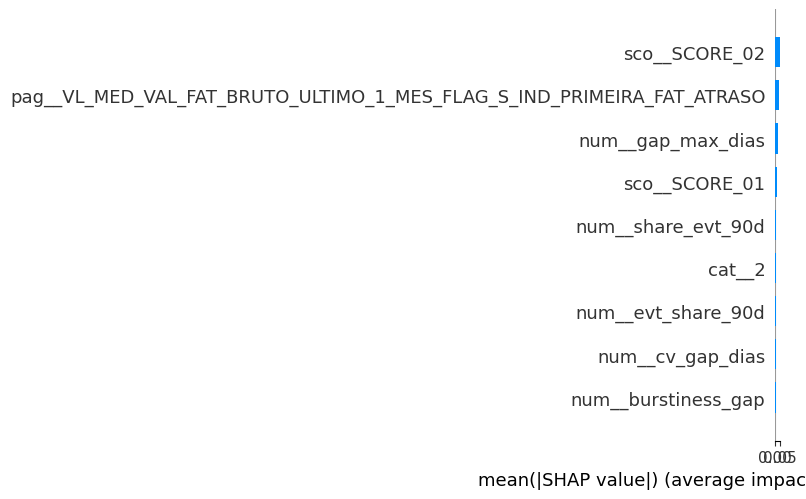

In [64]:
#importancia das variáveis:
shap.summary_plot(shap_values = rf_shap_values[:,:,1],
                  plot_type = 'bar',
                  feature_names = X_train_processed.columns)

/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


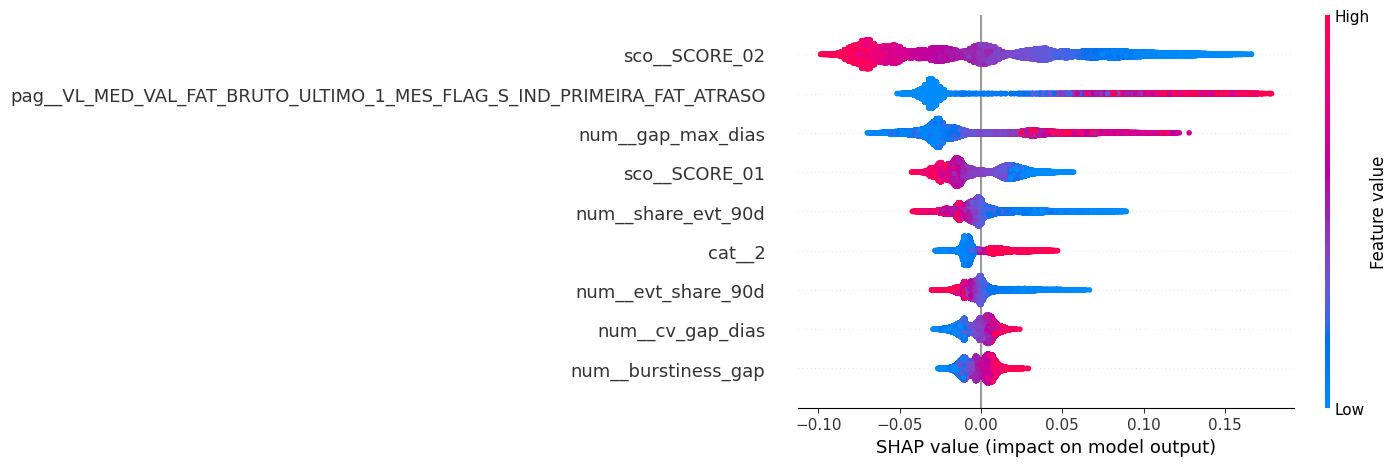

In [63]:
#importancia das variáveis:
shap.summary_plot(shap_values = rf_shap_values[:, :, 1],
                  features = X_train_processed,
                  feature_names = X_train_processed.columns,
                  plot_type = 'dot')

## Ordenação nos decis

### Treino

In [70]:
y_train.index = X_train_processed.index

bins = 10
tab = pd.concat([X_train_processed,y_train],axis=1).copy()
tab['score'] = algoritmo.predict_proba(tab.drop(columns=['FPD_SCORE_x']))[:,0]
tab['decile'] = pd.qcut(tab['score'], bins, labels=False)

# Criar tabela detalhada
table = tab.groupby('decile').agg(
    min_score=pd.NamedAgg(column='score', aggfunc='min'),
    max_score=pd.NamedAgg(column='score', aggfunc='max'),
    event_rate=pd.NamedAgg(column='FPD_SCORE_x', aggfunc='mean'),
    volume=pd.NamedAgg(column='FPD_SCORE_x', aggfunc='size'),
    qt_bads=pd.NamedAgg(column='FPD_SCORE_x', aggfunc=lambda x: (x == 1).sum()),
    perc_total_bads=pd.NamedAgg(column='FPD_SCORE_x', aggfunc=lambda x: (x == 1).sum()/tab[tab.FPD_SCORE_x == 1].shape[0])
).reset_index()
table['min_score'] = 1000*table['min_score']
table['max_score'] = 1000*table['max_score']
table_train = table[['decile','event_rate','perc_total_bads']]
table_train.rename(columns={'event_rate':'event_rate_train','perc_total_bads':'perc_total_bads_train'},inplace=True)
table_train

/tmp/ipython-input-1275218580.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_train.rename(columns={'event_rate':'event_rate_train','perc_total_bads':'perc_total_bads_train'},inplace=True)


,decile,event_rate_train,perc_total_bads_train
0,0,0.609679,0.280793
1,1,0.397459,0.183053
2,2,0.301942,0.139055
3,3,0.231799,0.106757
4,4,0.181050,0.083380
5,5,0.145137,0.066844
6,6,0.117737,0.054225
7,7,0.085617,0.039429
8,8,0.063622,0.029300
9,9,0.037268,0.017164


### Teste

In [71]:
y_test.index = X_test_processed.index

bins = 10
tab = pd.concat([X_test_processed,y_test],axis=1).copy()
tab['score'] = algoritmo.predict_proba(tab.drop(columns=['FPD_SCORE_x']))[:,0]
tab['decile'] = pd.qcut(tab['score'], bins, labels=False)

# Criar tabela detalhada
table = tab.groupby('decile').agg(
    min_score=pd.NamedAgg(column='score', aggfunc='min'),
    max_score=pd.NamedAgg(column='score', aggfunc='max'),
    event_rate=pd.NamedAgg(column='FPD_SCORE_x', aggfunc='mean'),
    volume=pd.NamedAgg(column='FPD_SCORE_x', aggfunc='size'),
    qt_bads=pd.NamedAgg(column='FPD_SCORE_x', aggfunc=lambda x: (x == 1).sum()),
    perc_total_bads=pd.NamedAgg(column='FPD_SCORE_x', aggfunc=lambda x: (x == 1).sum()/tab[tab.FPD_SCORE_x == 1].shape[0])
).reset_index()
table['min_score'] = 1000*table['min_score']
table['max_score'] = 1000*table['max_score']
table_test = table[['decile','event_rate','perc_total_bads']]
table_test.rename(columns={'event_rate':'event_rate_test','perc_total_bads':'perc_total_bads_test'},inplace=True)
table_test

/tmp/ipython-input-3200012293.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_test.rename(columns={'event_rate':'event_rate_test','perc_total_bads':'perc_total_bads_test'},inplace=True)


,decile,event_rate_test,perc_total_bads_test
0,0,0.567612,0.247991
1,1,0.406447,0.177578
2,2,0.310715,0.135752
3,3,0.248088,0.108390
4,4,0.202594,0.088514
5,5,0.165634,0.072359
6,6,0.140064,0.061194
7,7,0.108412,0.047365
8,8,0.084309,0.036835
9,9,0.054980,0.024021


In [72]:
summary = pd.merge(table_train,table_test,on='decile',how='inner')
summary

,decile,event_rate_train,perc_total_bads_train,event_rate_test,perc_total_bads_test
0,0,0.609679,0.280793,0.567612,0.247991
1,1,0.397459,0.183053,0.406447,0.177578
2,2,0.301942,0.139055,0.310715,0.135752
3,3,0.231799,0.106757,0.248088,0.108390
4,4,0.181050,0.083380,0.202594,0.088514
5,5,0.145137,0.066844,0.165634,0.072359
6,6,0.117737,0.054225,0.140064,0.061194
7,7,0.085617,0.039429,0.108412,0.047365
8,8,0.063622,0.029300,0.084309,0.036835
9,9,0.037268,0.017164,0.054980,0.024021


Insight:
- No geral, o modelo anterior é pior e mais instável que o atual.
- A % de inadimplentes em relação ao total existente nos primeiros decis ficou melhor, indo de 18,5% no decil 0 para 19,6% por ex.
- A % de inadimplentes dentro de cada decil também melhorou, no decil 0 por ex tempos 44,6% agora contra 42,1% do anterior.
- No geral, esse modelo está ligeiramente superior ao modelo 4 que é melhor que o 5.

### Visualização Gráfica

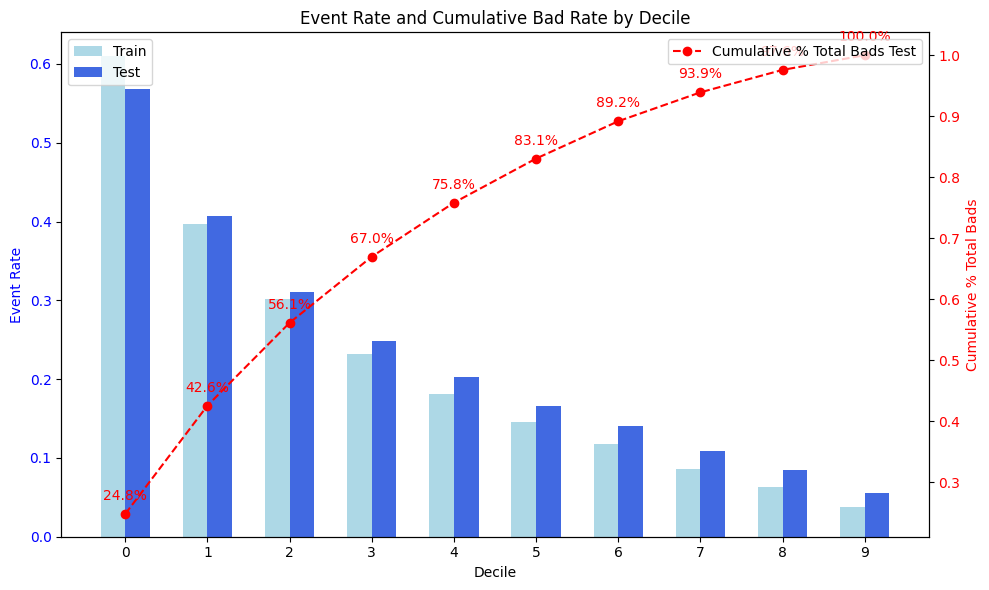

In [73]:
# Plotando o gráfico de barras para Event Rate por Decil
barWidth = 0.3
r1 = np.arange(len(summary))
r2 = [x + barWidth for x in r1]

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(r1, summary['event_rate_train'], color='lightblue', width=barWidth, label='Train')
ax1.bar(r2, summary['event_rate_test'], color='royalblue', width=barWidth, label='Test')

ax1.set_xlabel('Decile')
ax1.set_ylabel('Event Rate', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Event Rate and Cumulative Bad Rate by Decile')
ax1.set_xticks([r + barWidth / 2 for r in range(len(summary))])
ax1.set_xticklabels(summary['decile'])
ax1.legend(loc='upper left')

# Calculate cumulative sum for perc_total_bads_test
summary['cumulative_perc_total_bads_test'] = summary['perc_total_bads_test'].cumsum()

# Create a second y-axis for the cumulative sum
ax2 = ax1.twinx()
ax2.plot([r + barWidth / 2 for r in range(len(summary))], summary['cumulative_perc_total_bads_test'], color='red', marker='o', linestyle='--', label='Cumulative % Total Bads Test')
ax2.set_ylabel('Cumulative % Total Bads', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

# Add percentage labels to the cumulative bad rate line
for i, (x, y) in enumerate(zip([r + barWidth / 2 for r in range(len(summary))], summary['cumulative_perc_total_bads_test'])):
    ax2.annotate(f'{y:.1%}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', color='red')

fig.tight_layout()
plt.show()

Insight final:
- No geral, o modelo atual é muito mais performatico que o modelo anterior além de ser mais estável. Isso se deve principalmente a novas variáveis explicativas adicionadas pela base de atraso.
- O Modelo aumentou em 0.006 pontos o KS.
- Devido diminuição da base de dados total,devido o modelo ser aplicado somente para clientes com histórico de atraso, foi possível treinar o modelo com toda as linhas da base de dados disponíveis.
- Esse será o modelo Baseline para os clientes com histórico de dados de atraso enquanto terá outro para cliente sem histórico de atraso,  essa estratégia é mais performatica do que colocar toda base em um único modelo.
- Ao contrário dos modelos anteriores em que Light GBM ou Regressão Logistica foram os melhores, nesse caso o mais performático foi Random Forrest.
- Considerando a performance e o KS atual, o modelo melhorou mas ainda não atende as métricas de meta, uma vez que valor é menor considerando o benchmarking de mercado e também está bem menor em relação ao modelo atual da claro(KS=33.1).

Tentativas de otimização de performance:
- Aumento de % amostral para treinamento, mais que o atual não é suportado pelo Colab de 0,1 para 0,3, ganhando +-0.005 de ks
- Adicionado no feature selection o modelo IV após seleção via random forest, reduzindo de 20 para 8 features e elevando o ks em +-0.02

## Salvar melhor modelo

In [51]:
#salvando pickle do modelo para futura utilização.
import pickle
#Pickle variaveis do modelo:
with open('/content/drive/MyDrive/bases_CLARO_CREDITO/vars_baseline_atraso.pkl', 'wb') as f:
    pickle.dump(X_train_processed.columns, f)

# Salvar a preparação dos dados:
with open('/content/drive/MyDrive/bases_CLARO_CREDITO/preprocessor_baseline_atraso.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

#Pickle configuração modelo treinado:
with open('/content/drive/MyDrive/bases_CLARO_CREDITO/clf_baseline_atraso.pkl', 'wb') as file:
  pickle.dump(algoritmo, file)